In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, StandardScaler

In [2]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [3]:
def get_performance(df, match_id):
    match_df = df[df["match_id"] == match_id]
    eval_df = match_df.copy()

    # Explode the columns to duplicate columns for each player
    eval_df["player_id"] = None
    for i in eval_df.index:
        eval_df.at[i, "player_id"] = (1, 2)
    eval_df = (
        eval_df.explode("player_id")
        .reset_index(names="point_id")
        .set_index(["point_id", "player_id"])
    )

    # Assign info to the corresponding player
    sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
    eval_df_spec_criteria = [True, True, True, False, False]
    for col in sep_cols:
        eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

    # Victor by server or receiver
    eval_df["victor_by_server"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]),
        axis=1,
    )
    eval_df["victor_by_receiver"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]),
        axis=1,
    )
    sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
    eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

    # Entropy weight method (EWM)
    eval_df_spec = eval_df[sep_cols]
    scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
    norm_values = scaled_values / np.sum(scaled_values, axis=0)
    g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(
        norm_values * np.log(norm_values), axis=0
    )
    eval_df_spec_weights = g / np.sum(g)

    # TOPSIS
    topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_df_spec["performance"] = topsis.fit_predict()[1]

    # Store performance data
    p1_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 1, "performance"
    ]
    p2_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 2, "performance"
    ]
    p1_performance.index = p1_performance.index.droplevel("player_id")
    p2_performance.index = p2_performance.index.droplevel("player_id")
    return pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])

In [4]:
df = pd.read_csv("wimbledon.csv")

In [5]:
window_size = 6

In [6]:
player_name = "Carlos Alcaraz"
df_player = df[df["player1"] == player_name].copy()

In [7]:
def convert_df(df):
    df["swing"] = 0

    for match_id in df["match_id"].unique():
        df_performance = get_performance(df, match_id)
        df_perf_diff = df_performance["p1"] - df_performance["p2"]
        ser_momentum = df_perf_diff.rolling(window_size).sum()
        ser_momentum = ser_momentum.fillna(df_perf_diff.cumsum())
        for i, sign_diff in (
            np.sign(ser_momentum).diff().where(lambda x: x != 0).dropna().items()
        ):
            df.loc[i, "swing"] = 1 if sign_diff > 0 else -1

    def this_transform(x, kind, primary):
        target = f"{kind}_victor"
        if x[target] == primary:
            return 1
        if x[target] == 0:
            return 0
        return -1

    df_p1 = df.rename(columns=lambda x: x.replace("p1_", "")).rename(
        columns=lambda x: x.replace("p2_", "other_")
    )
    df_p1["is_server"] = df_p1.apply(lambda x: x["server"] == 1, axis=1)
    for kind in ["point", "game", "set"]:
        df_p1[f"this_{kind}"] = df_p1.apply(
            lambda x: this_transform(x, kind, 1), axis=1
        )
    df_p2 = df.rename(columns=lambda x: x.replace("p2_", "")).rename(
        columns=lambda x: x.replace("p1_", "other_")
    )
    df_p2["is_server"] = df_p2.apply(lambda x: x["server"] == 2, axis=1)
    for kind in ["point", "game", "set"]:
        df_p2[f"this_{kind}"] = df_p1.apply(
            lambda x: this_transform(x, kind, 2), axis=1
        )
    df_p2["swing"] = -df_p2["swing"]  # Invert the swing column
    df_info = pd.concat([df_p1, df_p2], keys=["p1", "p2"])

    valid_vals = ["0", "15", "30", "40", "AD"]
    valid_mask = df_info["score"].isin(valid_vals) & df_info["other_score"].isin(
        valid_vals
    )
    print(f"{len(df_info) - valid_mask.sum()} invalid out of {len(df_info)}")
    df_info = df_info[valid_mask]

    mapping = {"0": 0, "15": 1, "30": 2, "40": 3, "AD": 4}
    df_info["feat_score"] = df_info["score"].map(mapping)
    df_info["feat_score_diff"] = df_info["feat_score"] - df_info["other_score"].map(
        mapping
    )
    df_info["feat_deuce_ad"] = 0
    for i in df_info.index:
        if df_info.loc[i, "score"] == "AD":
            df_info.at[i, "feat_deuce_ad"] = 1
        elif df_info.loc[i, "other_score"] == "AD":
            df_info.at[i, "feat_deuce_ad"] = -1
    df_info["feat_point_count"] = (
        df_info.groupby(
            (df_info["game_no"] != df_info["game_no"].shift(1)).cumsum()
        ).cumcount()
        + 1
    )

    df_info["feat_game_diff"] = df_info["games"] - df_info["other_games"]
    df_info["feat_set_diff"] = df_info["sets"] - df_info["other_sets"]

    df_info["feat_cont_victors"] = (
        (df_info["this_point"] == 1)
        .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
        .cumsum()
    )
    df_info["feat_cont_losers"] = (
        (df_info["this_point"] == -1)
        .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
        .cumsum()
    )

    df_info["feat_unf_err"] = df_info["unf_err"]
    df_info["feat_unf_errs_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
        "unf_err"
    ].cumsum()
    df_info["feat_unf_errs_set"] = df_info.groupby(["match_id", "set_no"])[
        "unf_err"
    ].cumsum()
    df_info["feat_unf_err_oppn"] = df_info["other_unf_err"]
    df_info["feat_double_fault"] = df_info["double_fault"]
    df_info["feat_double_faults_game"] = df_info.groupby(
        ["match_id", "set_no", "game_no"]
    )["double_fault"].cumsum()
    df_info["feat_double_faults_set"] = df_info.groupby(["match_id", "set_no"])[
        "double_fault"
    ].cumsum()
    df_info["feat_double_fault_oppn"] = df_info["other_double_fault"]

    df_info["feat_ace"] = df_info["ace"]
    df_info["feat_aces_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
        "ace"
    ].cumsum()
    df_info["feat_aces_set"] = df_info.groupby(["match_id", "set_no"])["ace"].cumsum()
    df_info["feat_ace_oppn"] = df_info["other_ace"]
    df_info["feat_winner"] = df_info["winner"]
    df_info["feat_winners_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
        "winner"
    ].cumsum()
    df_info["feat_winners_set"] = df_info.groupby(["match_id", "set_no"])[
        "winner"
    ].cumsum()
    df_info["feat_winner_oppn"] = df_info["other_winner"]

    df_info["feat_break_pt_missed"] = df_info["break_pt_missed"]
    df_info["feat_break_pt_won"] = df_info["break_pt_won"]
    df_info["feat_break_pt_oppn_missed"] = df_info["other_break_pt_missed"]
    df_info["feat_break_pt_oppn_won"] = df_info["other_break_pt_won"]

    df_info["feat_speed_mph"] = df_info["speed_mph"] * df_info["is_server"].map(
        {True: 1, False: 0}
    )
    df_info["feat_speed_mph_oppn"] = df_info["speed_mph"] * df_info["is_server"].map(
        {True: 0, False: 1}
    )

    df_info["feat_distance_run"] = df_info["distance_run"]
    df_info["feat_distance_run_game"] = df_info.groupby(
        ["match_id", "set_no", "game_no"]
    )["distance_run"].cumsum()

    df_info["feat_net_pt"] = df_info["net_pt"]
    df_info["feat_net_pt_won"] = df_info["net_pt_won"]

    df_info["feat_is_server"] = df_info["is_server"].astype(int)
    df_info["feat_rally_count"] = df_info["rally_count"]

    df_info["elapsed_time_td"] = pd.to_timedelta(df_info["elapsed_time"])
    df_info["feat_time"] = (
        df_info.groupby("match_id")["elapsed_time_td"].diff().dt.total_seconds()
    )
    df_info["feat_time"] = df_info["feat_time"].fillna(0)

    df_info["swing"] = df_info["swing"].where(df_info["swing"] == 0, 1)
    df_info = df_info[df_info.index.get_level_values(0) == "p1"]
    df_info = df_info.filter(regex="^feat|^swing$")
    df_info = df_info.rename(columns=lambda x: x.replace("feat_", ""))

    for feat in df_info.columns:
        nan_count = df_info[feat].isna().sum()
        if nan_count > 0:
            print(f"{feat} has {nan_count} missing values")
    df_info[:] = SimpleImputer(strategy="most_frequent").fit_transform(df_info)
    assert not df_info.isna().any().any()

    return df_info

In [8]:
df_info = convert_df(df)

688 invalid out of 14568
speed_mph has 716 missing values
speed_mph_oppn has 716 missing values


In [9]:
df_info_player = convert_df(df_player)

70 invalid out of 2414
speed_mph has 39 missing values
speed_mph_oppn has 39 missing values


In [10]:
def plot_correlation(df_info, *, method, scipy_func, description, storage):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

    # Correlation coefficient
    correlation = (
        df_info.corr(method=method)["swing"].drop("swing", axis=0).sort_values()
    )
    bars = ax1.barh(correlation.index, correlation)
    ax1.bar_label(bars, fmt="%.3f", padding=5, fontsize=8)
    xlim = ax1.get_xlim()
    ax1.set_xlim(xlim[0] - 0.01, xlim[1] + 0.01)
    ax1.set_title("Coefficient")
    ax1.tick_params(axis="both", labelsize=8)

    # P-value
    correlation_p = (
        df_info.corr(lambda x, y: scipy_func(x, y).pvalue)["swing"]
        .drop("swing", axis=0)
        .sort_values(ascending=False)
    )
    p_bars = ax2.barh(correlation_p.index, correlation_p, color="lightgrey")
    ax2.bar_label(p_bars, fmt="%.1e", padding=5, fontsize=8)
    ax2.axvline(0.05, color="red", linestyle="--", lw=1)
    xlim = ax2.get_xlim()
    ax2.set_xlim(0, xlim[1] + 0.1)
    ax2.set_title("P-value")
    ax2.tick_params(axis="both", labelsize=8)

    storage[method] = (correlation, correlation_p)
    plt.suptitle(f"{description} correlation of various factors with the swing")
    plt.tight_layout()
    plt.show()

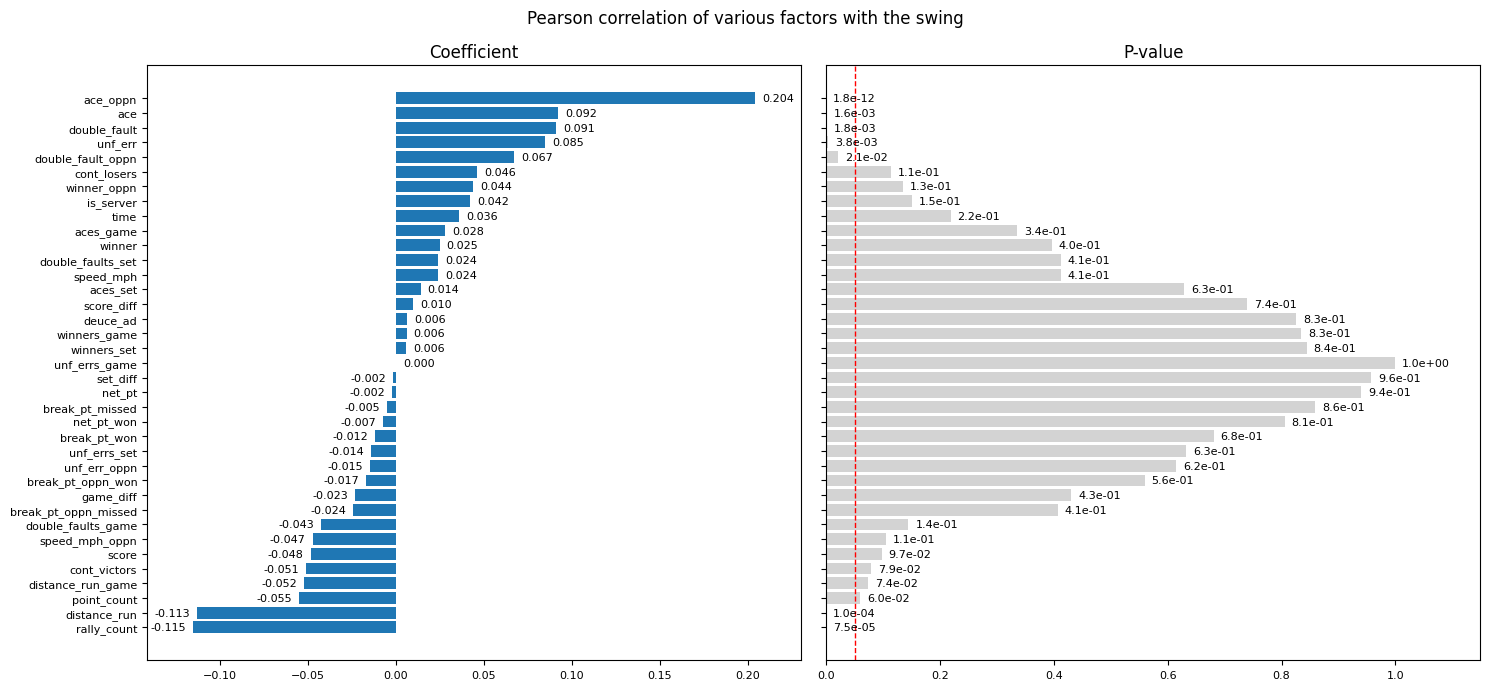

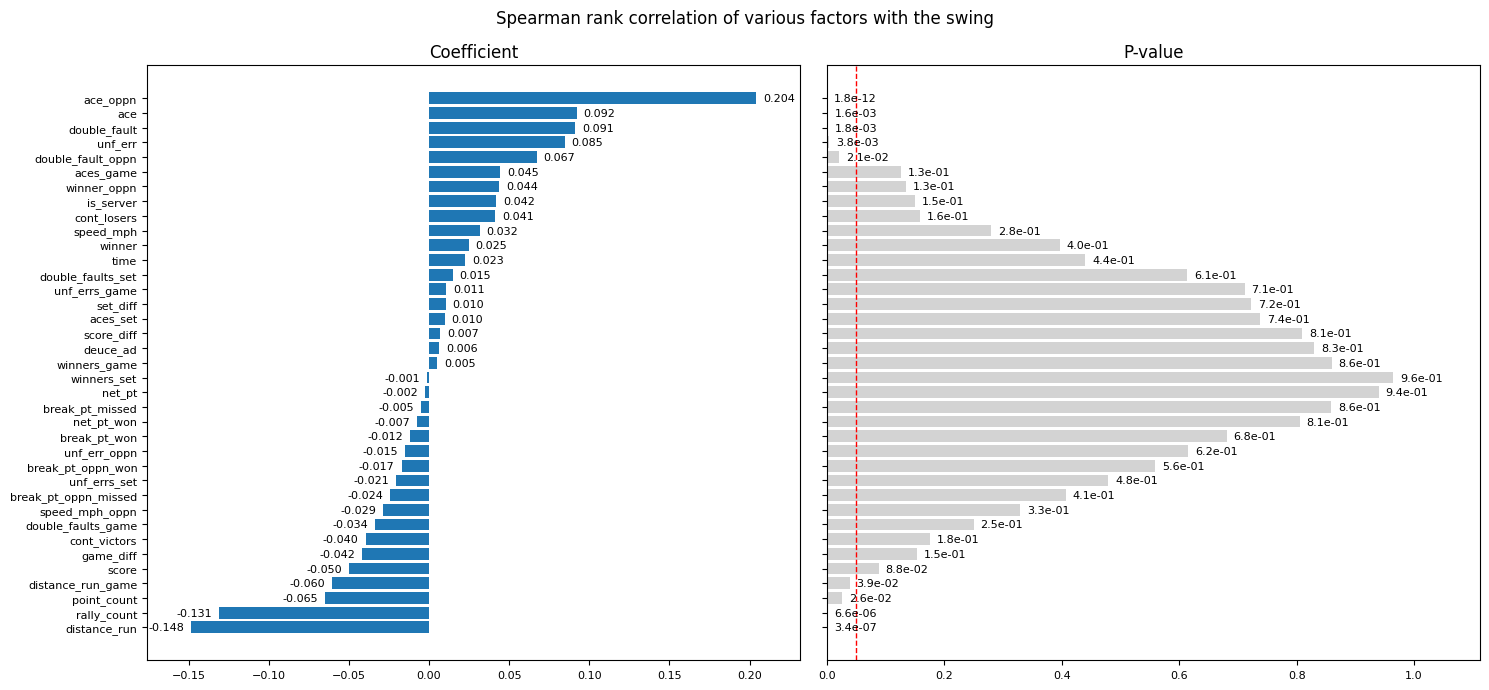

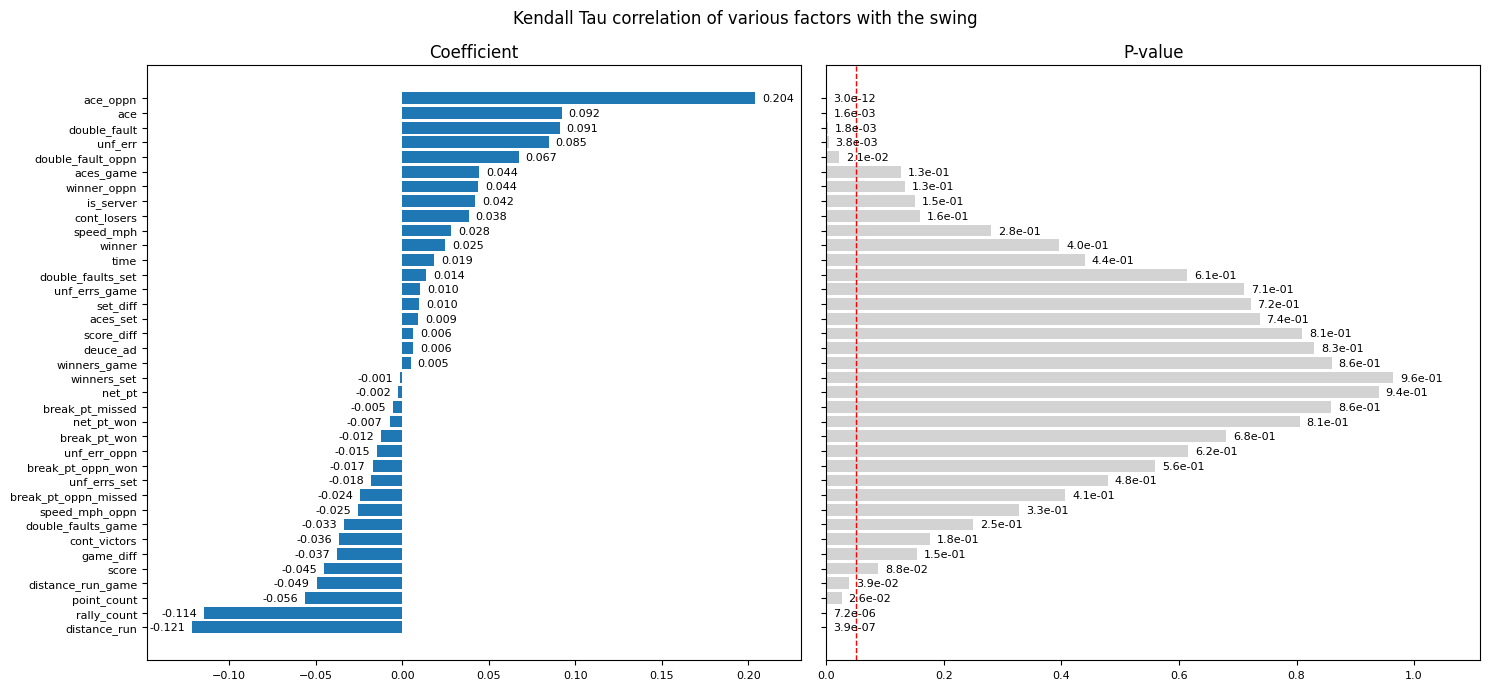

In [11]:
correlation_storage = {}
plot_correlation(
    df_info_player,
    method="pearson",
    scipy_func=stats.pearsonr,
    description="Pearson",
    storage=correlation_storage,
)
plot_correlation(
    df_info_player,
    method="spearman",
    scipy_func=stats.spearmanr,
    description="Spearman rank",
    storage=correlation_storage,
)
plot_correlation(
    df_info_player,
    method="kendall",
    scipy_func=stats.kendalltau,
    description="Kendall Tau",
    storage=correlation_storage,
)

Training only with the player's data.

In [12]:
selected_method = "pearson"
selected_corr, selected_corrp = correlation_storage[selected_method]
selected_features = selected_corrp[selected_corrp <= 0.05].index
X, y = df_info_player[selected_features], df_info_player["swing"]
X.shape, y.shape

((1172, 7), (1172,))

In [13]:
no_swing_count, swing_count = (y == 0).sum(), (y == 1).sum()
print(f"No swing: {no_swing_count}; Swing: {swing_count}")
sampling_strategy = {0: no_swing_count, 1: max(int(no_swing_count / 10), swing_count)}
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("sample", SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
        ("clf", RandomForestClassifier(n_estimators=500, random_state=42)),
    ]
)
pipeline.fit(X, y)

No swing: 974; Swing: 198


Pipeline(steps=[('scaler', StandardScaler()),
                ('sample',
                 SMOTE(random_state=42, sampling_strategy={0: 974, 1: 198})),
                ('clf',
                 RandomForestClassifier(n_estimators=500, random_state=42))])

In [14]:
clf = pipeline["clf"]
pd.DataFrame({"feature": X.columns, "importance": clf.feature_importances_}).set_index("feature").sort_values("importance", ascending=False).T

feature,distance_run,rally_count,ace_oppn,ace,unf_err,double_fault,double_fault_oppn
importance,0.875665,0.061666,0.032599,0.01174,0.010685,0.003985,0.00366


In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_info_player.loc[X.index, "swing_pred"] = clf.predict(X)
df_info_player["swing_pred"] = df_info_player["swing_pred"].astype(int)
df_info_player[["swing", "swing_pred"]].value_counts().to_frame().sort_index()

count
swing swing_pred       
0     0             426
      1             548
1     0             115
      1              83

Training with the same amount of data, but not restricted to the player.

In [16]:
X_comp, y_comp = df_info[selected_features], df_info["swing"]
X_comp, _, y_comp, _ = train_test_split(
    X_comp, y_comp, test_size=1 - X.shape[0] / X_comp.shape[0], random_state=42
)
X_comp.shape, y_comp.shape

((1172, 7), (1172,))

In [17]:
no_swing_count_comp, swing_count_comp = (y_comp == 0).sum(), (y_comp == 1).sum()
print(f"No swing: {no_swing_count_comp}; Swing: {swing_count_comp}")
sampling_strategy_comp = {0: no_swing_count_comp, 1: max(int(no_swing_count_comp / 10), swing_count_comp)}
pipeline_comp = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("sample", SMOTE(random_state=42, sampling_strategy=sampling_strategy_comp)),
        ("clf", RandomForestClassifier(n_estimators=500, random_state=42)),
    ]
)
pipeline_comp.fit(X_comp, y_comp)

No swing: 987; Swing: 185


Pipeline(steps=[('scaler', StandardScaler()),
                ('sample',
                 SMOTE(random_state=42, sampling_strategy={0: 987, 1: 185})),
                ('clf',
                 RandomForestClassifier(n_estimators=500, random_state=42))])

In [18]:
clf_comp = pipeline_comp["clf"]
pd.DataFrame({"feature": X_comp.columns, "importance": clf_comp.feature_importances_}).set_index("feature").sort_values("importance", ascending=False).T

feature,distance_run,rally_count,unf_err,ace_oppn,ace,double_fault_oppn,double_fault
importance,0.887198,0.062991,0.016843,0.01513,0.006286,0.005917,0.005634


In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_info = df_info.loc[X.index, :]
    df_info.loc[X.index, "swing_pred"] = clf_comp.predict(X)
df_info["swing_pred"] = df_info["swing_pred"].astype(int)
df_info[["swing", "swing_pred"]].value_counts().to_frame().sort_index()

count
swing swing_pred       
0     0             973
      1               1
1     0             198

Comparison of the two models.

In [20]:
def get_false_preds(df_info, indices, tolerance):
    false_positives, false_negatives = [], []
    for i, row in df_info.loc[indices].iterrows():
        ser_window = df_info.loc[
            df_info.index.get_level_values(1).isin(range(i[1], i[1] + tolerance + 1)),
            "swing",
        ]
        if row["swing_pred"] == 1:  # Predicted positive
            if len(ser_window[ser_window == 1]) == 0:  # No positive in window
                false_positives.append(i)
        else:  # Predicted negative
            if len(ser_window[ser_window == 0]) == 0:  # No negative in window
                false_negatives.append(i)
    return false_positives, false_negatives

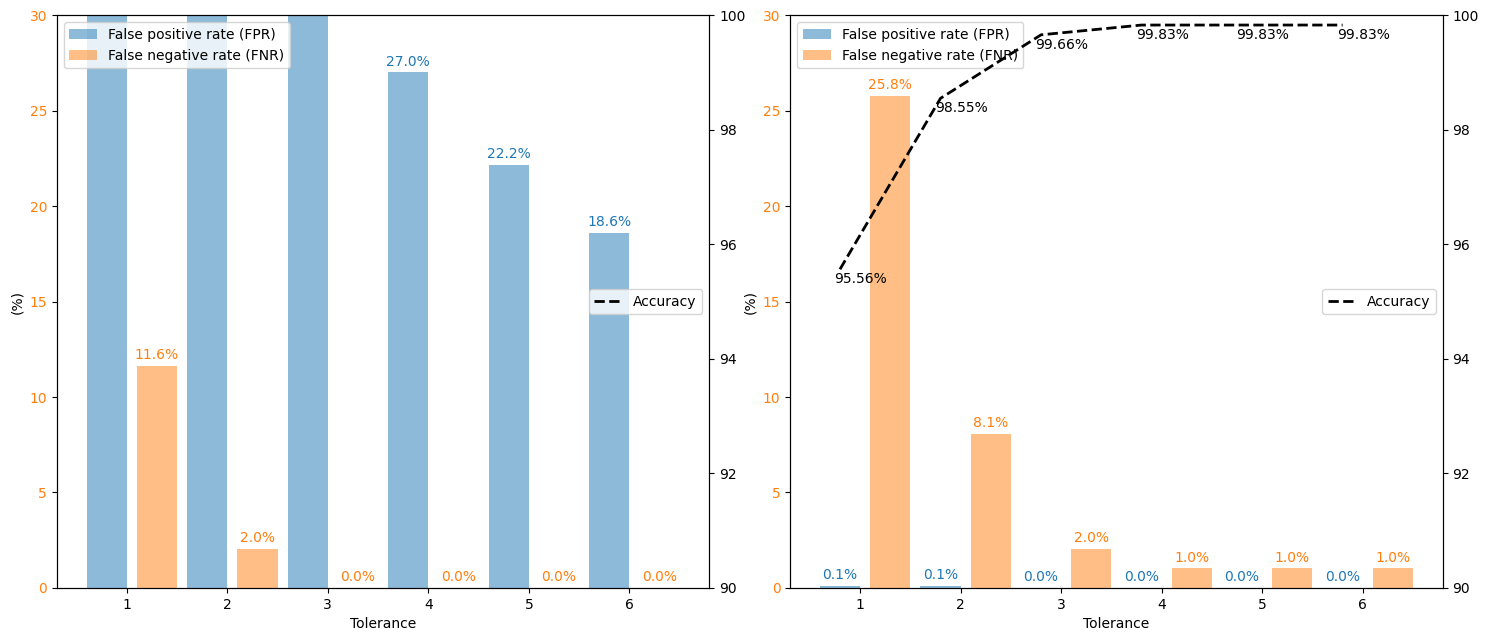

In [23]:
n_positives, n_negatives = len(y[y == 1]), len(y[y == 0])
fig = plt.figure(figsize=(14, 7))
subfig1, subfig2 = fig.subfigures(1, 2, width_ratios=[1, 1], wspace=0.1)

tolerances = np.arange(1, 7)
for subfig, cur_df in zip([subfig1, subfig2], [df_info_player, df_info]):
    subax = subfig.subplots()
    accs, fp_percs, fn_percs = [], [], []
    for tol in tolerances:
        false_positives, false_negatives = get_false_preds(cur_df, y.index, tol)
        fp, fn = len(false_positives), len(false_negatives)
        tp, tn = n_positives - fn, n_negatives - fp
        accs.append((tp + tn) / len(y) * 100)
        fp_percs.append(fp / (fp + tn) * 100)
        fn_percs.append(fn / (fn + tp) * 100)

    rects_fp = subax.bar(
        tolerances, fp_percs, width=0.4, label="False positive rate (FPR)", alpha=0.5
    )
    subax.bar_label(rects_fp, fmt="%.1f%%", padding=3, color="tab:blue")
    rects_fn = subax.bar(
        tolerances + 0.5, fn_percs, width=0.4, label="False negative rate (FNR)", alpha=0.5
    )
    subax.bar_label(rects_fn, fmt="%.1f%%", padding=3, color="tab:orange")
    subax.set_xticks(tolerances + 0.2)
    subax.set_xticklabels(tolerances)
    subax.set_xlabel("Tolerance")
    subax.set_ylabel("(%)")
    subax.set_ylim(0, 30)
    subax.tick_params(axis="y", labelcolor="tab:orange")
    subax.legend(loc="upper left")
    subax_ = subax.twinx()
    subax_.plot(tolerances, accs, label="Accuracy", color="black", lw=2, linestyle="--")
    for i, (tolerance, acc) in enumerate(zip(tolerances, accs)):
        subax_.annotate(
            f"{acc:.2f}%",
            (tolerance, acc),
            textcoords="offset points",
            xytext=(15, -10),
            ha="center",
            fontsize=10,
        )
    subax_.set_ylim(90, 100)
    subax_.legend(loc="center right")

fig.tight_layout()
plt.show()